In [7]:
# =============================================================================
# Package Set Up
# =============================================================================
import sys
!{sys.executable} -m pip install numpy pandas matplotlib networkx rasterio geopandas scipy plotly

  Using cached pandas-2.3.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached rasterio-1.4.3-cp313-cp313-win_amd64.whl.metadata (9.4 kB)
  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached scipy-1.16.2-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached plotly-6.3.1-py3-none-any.whl.metadata (8.5 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp313-cp313-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-11.3.0-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached pypa


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\yamff\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [3]:
# =============================================================================
# Environment Variables
# =============================================================================
# data_dir = Path("../data")
#   - 'data_dir' specifies the folder where all project data files are stored.
#   - "../data" points to the 'data' folder one level above the current notebook/script.
#
# dem_path = data_dir / "hyd_na_dem_30s.tif"
#   - 'dem_path' specifies the path to the DEM file.
#     Here it points to "hyd_na_dem_30s.tif" in the 'data_dir' folder.
#   - feel free to change this to another file for testing, but the file
#     has to be in the data folder
#
# slice_size = 'number'
#   - Defines the size of the DEM slice for testing.
#   - 'number' x 'number' is the amount of nodes that will be displayed
#   - Defaulted to 200 for quick visualization.
# =============================================================================
from pathlib import Path
data_dir = Path("../data")
dem_path = data_dir / "hyd_na_dem_30s.tif"
slice_size = 200
print("Environment Variables Loaded")

Environment Variables Loaded


In [10]:
# =============================================================================
# Imports for the Project
# =============================================================================
# import numpy as np
#   - Provides fast numerical computations and multi-dimensional arrays.
#   - Used to store DEMs (Digital Elevation Models) as 2D arrays and perform array operations.
#
# import networkx as nx
#   - Library for creating, manipulating, and analyzing graphs.
#   - Represents the DEM as a terrain graph where nodes = grid cells and edges = flow connections.
#
# import rasterio
#   - Reads and writes geospatial raster data (e.g., GeoTIFF DEM files).
#   - Loads HydroSHEDS DEM files and accesses both elevation values and georeferencing info.
#
# import matplotlib.pyplot as plt
#   - Classic 2D plotting library.
#   - Used to visualize DEM slices as terrain heatmaps or small graphs in 2D.
#
# import plotly.graph_objects as go
#   - Interactive plotting library for Python.
#   - Used to create rotatable, zoomable 3D visualizations of terrain graphs.
#
# from pathlib import Path
#   - Provides clean, platform-independent file path management.
#   - Handles paths to DEM files.
# =============================================================================

import numpy as np
import networkx as nx
import rasterio
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"
print("Imports Loaded")

Imports Loaded


In [5]:
# =============================================================================
# Load Digital Elevation Model Data
# =============================================================================
# with rasterio.open(dem_path) as src:
#   - 'rasterio.open()' opens the GeoTIFF DEM file for reading.
#
# elevation = src.read(1)
#   - 'src.read(1)' reads the first band of the raster
#     into a 2D NumPy array called 'elevation'.
#
# transform = src.transform
#   - 'src.transform' stores the affine transform that maps array indices
#     to real-world coordinates (longitude/latitude or projected coordinates).
# =============================================================================

with rasterio.open(dem_path) as src:
    elevation = src.read(1)
    transform = src.transform

print("DEM loaded:", elevation.shape)

DEM loaded: (6960, 10320)


In [6]:
# =============================================================================
# Build terrain graph from defined DEM slice
# =============================================================================
# elevation_slice = elevation[:slice_size, :slice_size]
#   - Extracts a 2D NumPy array slice from the full DEM.
#
# rows, cols = elevation_slice.shape
#   - Get the number of rows and columns in the DEM slice.
#
# G = nx.DiGraph()
#   - Initialize a directed graph using NetworkX.
#
# for r in range(rows):
#     for c in range(cols):
#         G.add_node((r, c), elevation=elevation_slice[r, c])
#         - Each cell in the DEM slice becomes a node.
#         - Node attribute 'elevation' stores the cell's elevation value.
#
#         for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
#             nr, nc = r + dr, c + dc
#             if 0 <= nr < rows and 0 <= nc < cols:
#                 if elevation_slice[nr, nc] <= elevation_slice[r, c]:
#                     G.add_edge((r, c), (nr, nc))
#         - Adds edges from the current node to its 4 neighbors (up, down, left, right)
#           if the neighbor's elevation is lower or equal (flow downhill).
#
# sample_nodes = list(G.nodes)[:'number']
#   - Select the first 'number' nodes from the graph G for visualization.
#   - Defaulted to 500 for quick visualization.
#
# H = G.subgraph(sample_nodes)
#   - Create a subgraph containing only the selected sample nodes and their edges.
# =============================================================================

elevation_slice = elevation[:slice_size, :slice_size]
rows, cols = elevation_slice.shape

G = nx.DiGraph()

for r in range(rows):
    for c in range(cols):
        G.add_node((r, c), elevation=elevation_slice[r, c])
        
        for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols:
                if elevation_slice[nr, nc] <= elevation_slice[r, c]:
                    G.add_edge((r, c), (nr, nc))

print("Graph built on slice:", rows, "x", cols)
print("Nodes:", len(G.nodes))
print("Edges:", len(G.edges))

sample_nodes = list(G.nodes)[:500]
H = G.subgraph(sample_nodes)

Graph built on slice: 200 x 200
Nodes: 40000
Edges: 159200


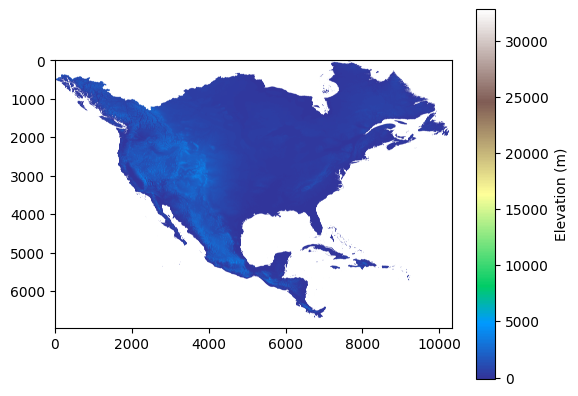

In [7]:
# =============================================================================
# Visualize DEM
# =============================================================================
# plt.imshow(elevation, cmap='terrain')
#   - Displays the 2D DEM array as an image.
#   - Each pixel represents a grid cell's elevation.
#   - 'cmap="terrain"' uses a colormap suitable for elevation/terrain.
#
# plt.colorbar(label='Elevation (m)')
#   - Adds a color bar indicating the mapping from color to elevation values.
#
# plt.show()
#   - Renders the plot in the notebook.
# =============================================================================

plt.imshow(elevation, cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.show()

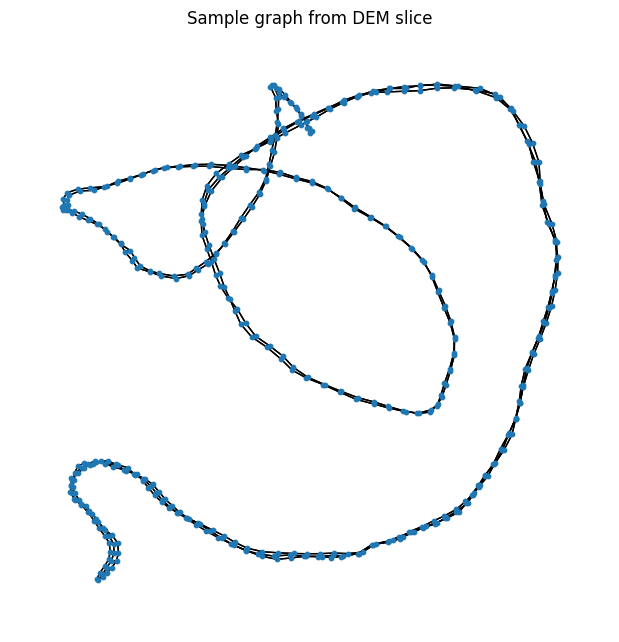

In [8]:
# =============================================================================
# Visualize Terrain Graph (Uninteractive) *Much Quicker than Interactive
# =============================================================================
# plt.figure(figsize=(6,6))
#   - Set the figure size for better readability.
#
# nx.draw(H, with_labels=False, node_size=10, arrows=False)
#   - Draw the subgraph H using NetworkX.
#   - with_labels=False: do not display node labels (makes plot cleaner).
#   - node_size=10: small nodes for dense graphs.
#   - arrows=False: hide edge arrows for simplicity.
#
# plt.title('string')
#   - Sets the title to the plot.
#   - Defaulted to "Sample graph from DEM slice"
#
# plt.show()
#   - Render the plot in the notebook.
# =============================================================================

plt.figure(figsize=(6,6))
nx.draw(H, with_labels=False, node_size=10, arrows=False)
plt.title("Sample graph from DEM slice")
plt.show()

In [13]:
# =============================================================================
# Visualize Terrain Graph (Interactive)
# =============================================================================
# pos = nx.spring_layout(H, dim=3)
#   - Computes 3D positions for nodes in the subgraph H using a force-directed (spring) layout.
#   - 'dim=3' ensures positions have x, y, z coordinates.
#
# x_nodes = [pos[n][0] for n in H.nodes]
# y_nodes = [pos[n][1] for n in H.nodes]
# z_nodes = [pos[n][2] for n in H.nodes]
#   - Extracts the x, y, z coordinates of each node into separate lists for plotting.
#
# edge_x, edge_y, edge_z = [], [], []
# for u, v in H.edges():
#     edge_x += [pos[u][0], pos[v][0], None]
#     edge_y += [pos[u][1], pos[v][1], None]
#     edge_z += [pos[u][2], pos[v][2], None]
#   - Prepares lists of coordinates for edges.
#   - 'None' separates edges so Plotly draws them individually.
#
# edge_trace = go.Scatter3d(
#     x=edge_x, y=edge_y, z=edge_z,
#     line=dict(width=1, color='black'),
#     hoverinfo='none',
#     mode='lines'
# )
#   - Creates a 3D scatter trace for edges as black lines.
#
# node_trace = go.Scatter3d(
#     x=x_nodes, y=y_nodes, z=z_nodes,
#     mode='markers',
#     marker=dict(size=4, color='blue')
# )
#   - Creates a 3D scatter trace for nodes as blue markers.
#
# fig = go.Figure(data=[edge_trace, node_trace])
# fig.update_layout(scene=dict(aspectmode='cube'))
#   - Combines nodes and edges into a single Plotly figure.
#   - Sets aspect mode to 'cube' for equal scaling in x, y, z axes.
# =============================================================================

pos = nx.spring_layout(H, dim=3)

x_nodes = [pos[n][0] for n in H.nodes]
y_nodes = [pos[n][1] for n in H.nodes]
z_nodes = [pos[n][2] for n in H.nodes]

edge_x, edge_y, edge_z = [], [], []
for u, v in H.edges():
    edge_x += [pos[u][0], pos[v][0], None]
    edge_y += [pos[u][1], pos[v][1], None]
    edge_z += [pos[u][2], pos[v][2], None]

edge_trace = go.Scatter3d(
    x=edge_x, y=edge_y, z=edge_z,
    line=dict(width=1, color='black'),
    hoverinfo='none',
    mode='lines'
)

node_trace = go.Scatter3d(
    x=x_nodes, y=y_nodes, z=z_nodes,
    mode='markers',
    marker=dict(size=4, color='blue')
)

fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(scene=dict(aspectmode='cube'), width=900, height=700)
fig.show()